# [IT8302] Applied Machine Learning: Titanic Classification

## Table of Contents
1. [Import Libraries](#1)
2. [Exploratory Data Analysis](#2)
3. [Data Pre-Processing](#3)
4. [Modelling](#4)
5. [Conclusion](#5)

__Introduction__  
This analysis focuses on using machine learning to build a model that predicts passenger survival during the Titanic disaster in 1912. Using passenger data such as name, age, gender, and socio-economic class, we aim to develop a model that effectively predicts survival outcomes.

__Datasets used__  
[Titanic Kaggle Dataset](https://www.kaggle.com/c/titanic/data)

# 1. Import Libraries <a id = '1'></a>

In [12]:
import warnings
from time import sleep

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from loguru import logger
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    RandomizedSearchCV,
    cross_val_score,
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier

warnings.filterwarnings("ignore")

# 2. Exploratory Data Analysis (EDA) <a id = '2'></a> 

Load the dataset and inspect the dataframe for values, data types, and nulls.

In [13]:
# Read train and test data
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

# Inspect
print(f"train.csv shape: {train_df.shape}")
print(f"test.csv shape: {test_df.shape}\n")

# Inspect dataframe
print(train_df.info())
train_df.head()

train.csv shape: (891, 12)
test.csv shape: (418, 11)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Get the total number of NA values in each column within the train datset

In [14]:
# Check train_df columns with missing values
col_nan_series = train_df.isnull().sum()
is_missing_yes = col_nan_series > 0
col_with_missing_values_series = col_nan_series[is_missing_yes]

print("Columns with missing values:")
print(col_with_missing_values_series)

Columns with missing values:
Age         177
Cabin       687
Embarked      2
dtype: int64


We first start by visualising key variables and their relationships with one of the most influential explanatory variables: `Pclass`. Passenger class (`Pclass`) likely reflects socio-economic stratification, which may have influenced survival outcomes. We examine trends within these strata as follows.

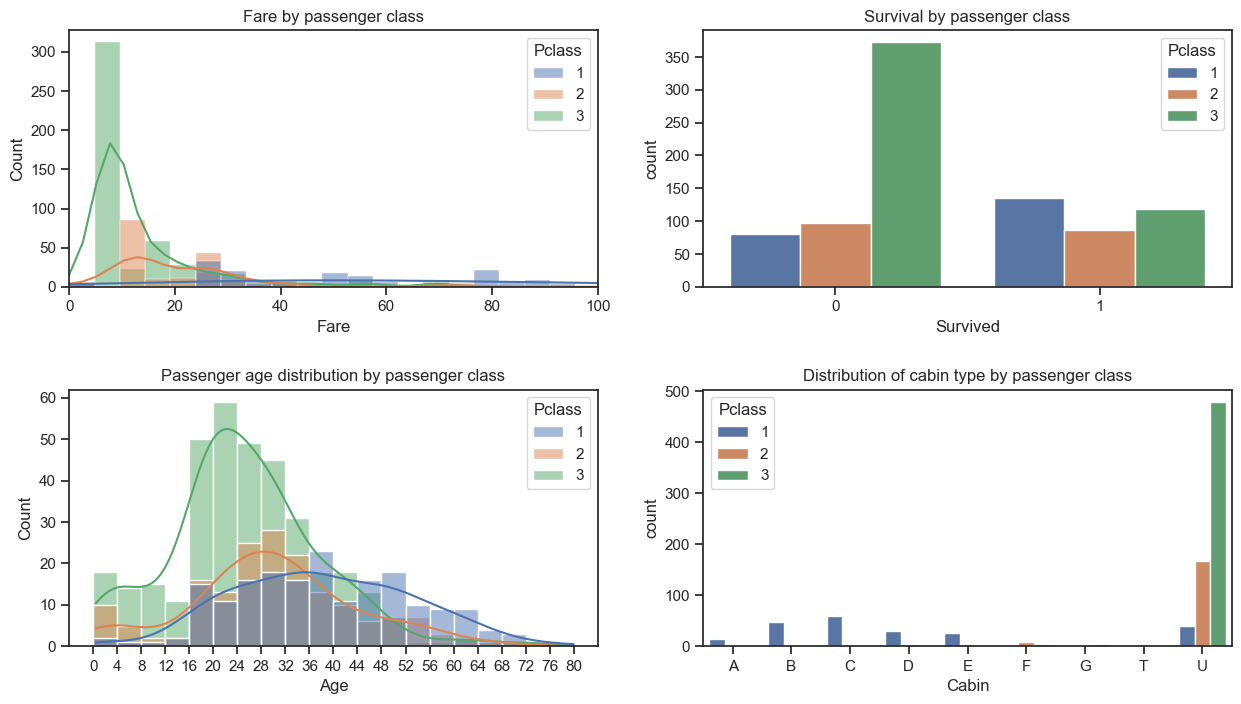

In [15]:
# Set theme and style
sns.set(style="ticks", palette=sns.color_palette("deep"))

# Set figure size for multiple plots
plt.figure(figsize=(15, 8))

# Fare by passenger class
plt.subplot(2, 2, 1)
sns.histplot(
    data=train_df,
    x="Fare",
    hue="Pclass",
    kde=True,
    palette=sns.color_palette("deep", n_colors=3),
)
plt.xlim(0, 100)
plt.title("Fare by passenger class")

# Survival by passenger class
plt.subplot(2, 2, 2)
sns.countplot(
    data=train_df,
    x="Survived",
    hue="Pclass",
    palette=sns.color_palette("deep", n_colors=3),
)
plt.title("Survival by passenger class")


# Passenger age distribution by passenger class
plt.subplot(2, 2, 3)
sns.histplot(
    data=train_df,
    x="Age",
    hue="Pclass",
    kde=True,
    bins=np.arange(0, 84, 4),
    palette=sns.color_palette("deep", n_colors=3),
)
plt.xticks(np.arange(0, 84, 4))
plt.title("Passenger age distribution by passenger class")

# Cabin by Pclass (does not seem very informative given majority of data is unknown)
plt.subplot(2, 2, 4)
sns.countplot(
    data=train_df,
    x=train_df["Cabin"].str.extract("([a-zA-Z])", expand=False).fillna("U"),
    hue="Pclass",
    palette=sns.color_palette("deep", n_colors=3),
    order=train_df["Cabin"]
    .str.extract("([a-zA-Z])", expand=False)
    .fillna("U")
    .sort_values(),
)
plt.title("Distribution of cabin type by passenger class")

plt.subplots_adjust(hspace=0.4)
plt.show()

Next, we analyse the distributions of passengers by survival status across:
- Age;
- Gender;
- Family size; and 
- Port of embarkation.

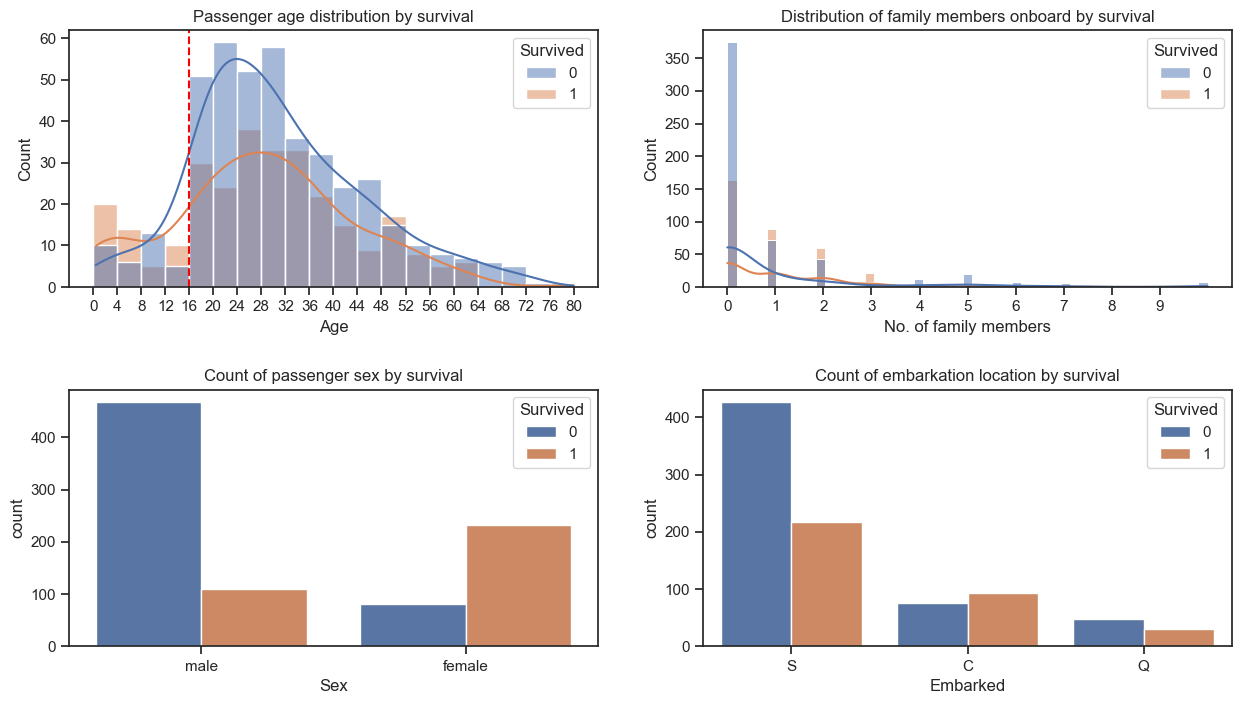

In [16]:
# Set theme and style
sns.set(style="ticks", palette=sns.color_palette("deep"))

# Set figure size for multiple plots
plt.figure(figsize=(15, 8))

# Passenger age distribution by survival
plt.subplot(2, 2, 1)
sns.histplot(data=train_df, x="Age", hue="Survived", kde=True, bins=np.arange(0, 84, 4))
plt.axvline(x=16, linestyle="--", color="red")
plt.xticks(np.arange(0, 84, 4))
plt.title("Passenger age distribution by survival")

# Distribution of family members onboard per passenger by survival
plt.subplot(2, 2, 2)
sns.histplot(
    data=train_df, x=train_df["SibSp"] + train_df["Parch"], hue="Survived", kde=True
)
plt.xticks(np.arange(0, 10, 1))
plt.xlabel("No. of family members")
plt.title("Distribution of family members onboard by survival")

# Count of passenger sex by survival
plt.subplot(2, 2, 3)
sns.countplot(data=train_df, x="Sex", hue="Survived")
plt.title("Count of passenger sex by survival")

# Count of embarkation location by survival
plt.subplot(2, 2, 4)
sns.countplot(data=train_df, x="Embarked", hue="Survived")
plt.title("Count of embarkation location by survival")

plt.subplots_adjust(hspace=0.4)
plt.show()

From our EDA, the following variables appear to be logical predictors of survival: Pclass, Sex, Fare, Age (categorised as minors/adults, cut-off ≤16 years old), and Family Size (categorised as alone/not alone).
- First-class passengers likely survived due to social inequality.
- Positive correlation between Fare (higher-paying passengers) and survival.
- Women and children were prioritised during evacuation.
- Passengers with small families (1–3 members) also showed higher survival rates.

We then plot a correlation heatmap to visualise corerlations between these variables and survivorship.

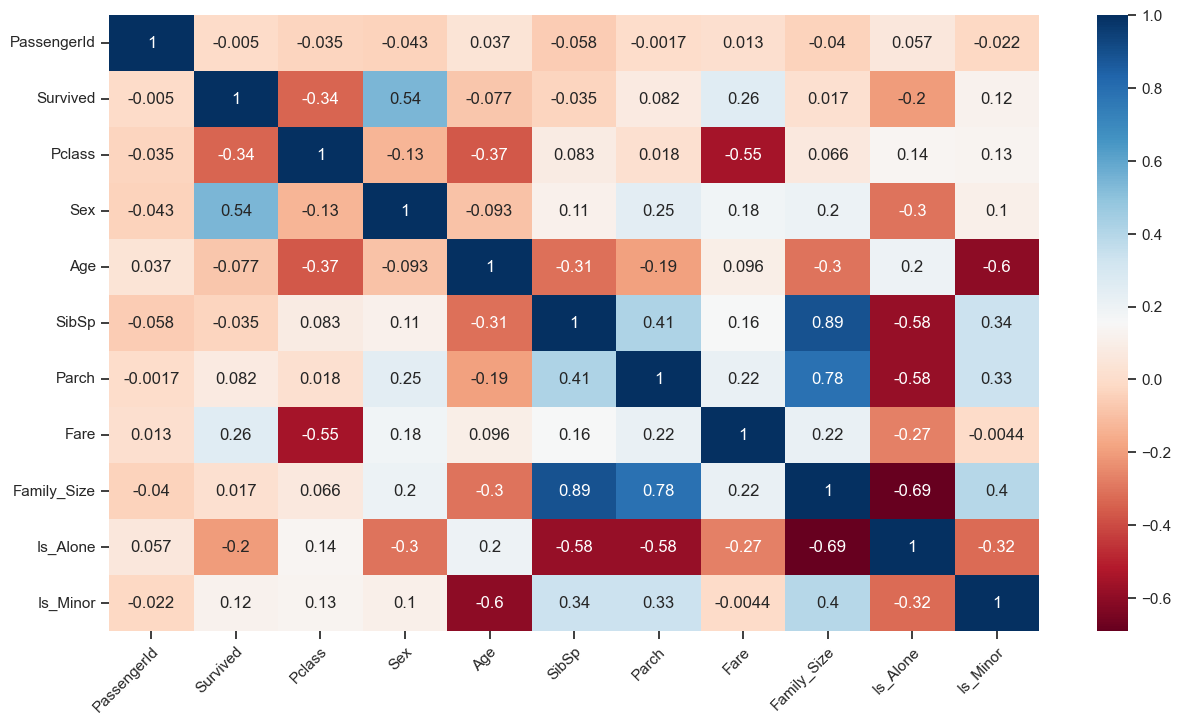

In [17]:
# Visualise correlations between numerical variables
corr_train_df = train_df.copy()

# Feature engineering to elucidate better relationships with response variable ("Survived")
# Label encode sex for visualisation purposes
corr_train_df["Sex"] = corr_train_df["Sex"].map({"male": 0, "female": 1})

# Combine sibling, spouse, parent, children into one variable: "Family_Size"
corr_train_df["Family_Size"] = corr_train_df["Parch"] + corr_train_df["SibSp"]

# Check correlation for passengers that are alone (potentially higher survival rate as they got nothing to abandon)
corr_train_df["Is_Alone"] = np.where(corr_train_df["Family_Size"] == 0, 1, 0)

# Check if minors/children were prioritised
corr_train_df["Is_Minor"] = np.where(corr_train_df["Age"] <= 16, 1, 0)

corr = corr_train_df.select_dtypes(include=["int64", "float64"]).corr()

plt.figure(figsize=(15, 8))
sns.heatmap(corr, annot=True, cmap="RdBu")
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.show()

With reference to the above heatmap, there is a moderate correlation between Pclass, Fare, and Sex with survivorship. Variables like Age, SibSp, and Parch show minimal correlation with survival unless new features are engineered:
- Is Minor (age ≤ 16); and
- Is Alone (no family members).

We also explore the relationship of feature-engineered categorical variables, such as each passgener's salutation and cabin type (if available) with survivorship, Is Minor and Is Alone features with survivorshop using simple count plots.

In [18]:
mapping_dict = {
    "Ms.": "Miss.",
    "Mlle.": "Miss.",
    "Mme.": "Mrs.",
    "Dr.": "Professional",
    "Major.": "Professional",
    "Rev.": "Professional",
    "Capt.": "Professional",
    "Col.": "Professional",
    "Jonkheer.": "Nobility",
    "Lady.": "Nobility",
    "Countess.": "Nobility",
    "Sir.": "Nobility",
    "Don.": "Nobility",
}
common_salutations = [
    "Mr.",
    "Miss.",
    "Mrs.",
    "Master.",
]

corr_train_df["Salutation"] = (
    corr_train_df["Name"].str.extract(r"( [a-zA-Z]+\.)", expand=False).str.strip()
)
corr_train_df["Salutation"] = corr_train_df["Salutation"].transform(
    lambda row: row
    if row in common_salutations
    else mapping_dict[row]
    if row in mapping_dict.keys()
    else "Others"
)

# Cabin classifier
# eda_df['Cabin'] = eda_df['Cabin'].str.extract("([a-zA-Z])").fillna("U")
corr_train_df["Cabin"] = corr_train_df["Cabin"].apply(
    lambda x: "U" if pd.isnull(x) else "C"
)

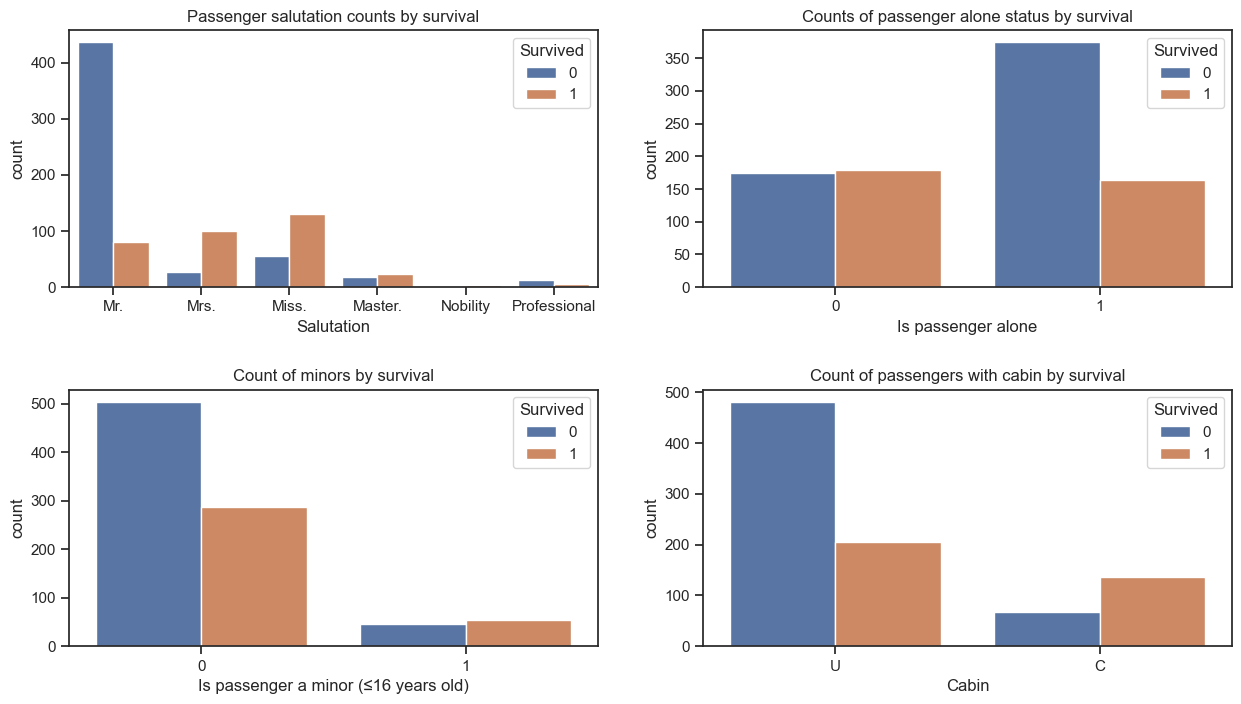

In [19]:
# Set theme and style
sns.set(style="ticks", palette=sns.color_palette("deep"))

# Set figure size for multiple plots
plt.figure(figsize=(15, 8))

# Passenger salutation counts by survival
plt.subplot(2, 2, 1)
sns.countplot(data=corr_train_df, x="Salutation", hue="Survived")
plt.title("Passenger salutation counts by survival")

# Distribution of family members onboard per passenger by survival
plt.subplot(2, 2, 2)
sns.countplot(data=corr_train_df, x="Is_Alone", hue="Survived")
plt.xlabel("Is passenger alone")
plt.title("Counts of passenger alone status by survival")

# Count of passenger sex by survival
plt.subplot(2, 2, 3)
sns.countplot(data=corr_train_df, x="Is_Minor", hue="Survived")
plt.xlabel("Is passenger a minor (≤16 years old)")
plt.title("Count of minors by survival")

# Count of passenger sex by survival
plt.subplot(2, 2, 4)
sns.countplot(data=corr_train_df, x="Cabin", hue="Survived")
plt.title("Count of passengers with cabin by survival")

plt.subplots_adjust(hspace=0.4)
plt.show()

# 3. Data Pre-Processing <a id = '3'></a> 

__Create pre-processing pipeline__  
Here, we developed a consistent and reusable pre-processing pipeline for transforming both training and test datasets. Specifically, we implement custom transformers using BaseEstimator and TransformerMixin to cater to our analysis' specific needs and maintain dataframe outputs for inspection.

The following transformers were created for our pre-processing pipeline:
- __Feature Selector__: Selects relevant features for analysis.
- __Group Mean Imputer__: Imputes Age and Fare using group means from Pclass (fitted on training data).
- __Mode Imputer__: Fills missing categorical values based on the mode from the training data.
- __Salutation Transformer__: Extracts salutations from passenger names.
- __Minor Categorizer__: Flags passengers as minors (<16 years).
- __Family Categorizer__: Determines if a passenger is traveling alone.
- __Cabin Classifier__: Categorizes cabin data.
- __One-Hot Encoder__: Encodes selected categorical variables.
- __Standard Scaler__: Scales numerical variables (Fare) using mean and standard deviation from the training dataset.

In [20]:
class SelectFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, variables):
        self.variables = variables

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.loc[:, self.variables]


class WithinGroupMeanImputer(BaseEstimator, TransformerMixin):
    def __init__(self, group_var, var_to_impute):
        self.group_var = group_var
        self.var_to_impute = var_to_impute

    def fit(self, X, y=None):
        X_ = X.copy()
        self.group_means = X_.groupby(self.group_var)[self.var_to_impute].mean()
        return self

    def transform(self, X):
        X_ = X.copy()
        X_[self.var_to_impute] = X_[self.var_to_impute].fillna(
            X_[self.group_var].map(self.group_means)
        )
        return X_


class SimpleImputerCustom(BaseEstimator, TransformerMixin):
    def __init__(self, variables, strategy):
        self.variables = variables
        self.strategy = strategy
        self.imp = SimpleImputer(missing_values=np.nan, strategy=self.strategy)

    def fit(self, X, y=None):
        X_ = X.copy()
        X_variables = X_.loc[:, self.variables]
        self.imp.fit(X_variables)
        return self

    def transform(self, X):
        X_ = X.copy()
        X_variables = X_.loc[:, self.variables]
        X_variables_transformed = pd.DataFrame(
            self.imp.transform(X_variables), columns=self.variables
        )
        X_.drop(self.variables, axis=1, inplace=True)
        X_[self.variables] = X_variables_transformed[self.variables].values
        return X_


class StandardScalerCustom(BaseEstimator, TransformerMixin):
    def __init__(self, variables):
        self.variables = variables
        self.stdscaler = StandardScaler()

    def fit(self, X, y=None):
        X_ = X.copy()
        X_variables = X_[self.variables]
        self.stdscaler.fit(X_variables)
        return self

    def transform(self, X):
        X_ = X.copy()
        X_variables = X_[self.variables]
        X_variables_transformed = pd.DataFrame(
            self.stdscaler.transform(X_variables), columns=X_variables.columns
        )
        X_.drop(X_variables.columns, axis=1, inplace=True)
        X_[X_variables.columns] = X_variables_transformed[X_variables.columns].values
        return X_


class SalutationTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, variables):
        self.variables = variables

    def fit(self, X, y=None):
        self.mapping_dict_ = {
            "Ms.": "Miss.",
            "Mlle.": "Miss.",
            "Mme.": "Mrs.",
            "Dr.": "Professional",
            "Major.": "Professional",
            "Rev.": "Professional",
            "Capt.": "Professional",
            "Col.": "Professional",
            "Jonkheer.": "Nobility",
            "Lady.": "Nobility",
            "Countess.": "Nobility",
            "Sir.": "Nobility",
            "Don.": "Nobility",
        }
        self.common_salutations_ = [
            "Mr.",
            "Miss.",
            "Mrs.",
            "Master.",
        ]
        return self

    def transform(self, X):
        X_ = X.copy()
        X_["Salutation"] = (
            X_[self.variables].str.extract(r"( [a-zA-Z]+\.)", expand=False).str.strip()
        )
        X_["Salutation"] = X_["Salutation"].transform(
            lambda row: row
            if row in self.common_salutations_
            else self.mapping_dict_[row]
            if row in self.mapping_dict_.keys()
            else "Others"
        )
        X_.drop(columns=[self.variables], inplace=True)
        return X_


class CabinClassifier(BaseEstimator, TransformerMixin):
    def __init__(self, variables):
        self.variables = variables

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_ = X.copy()
        X_variables_transformed = (
            # X_[self.variables].str.extract("([a-zA-Z])").fillna("U")
            X_[self.variables].apply(lambda x: 0 if pd.isnull(x) else 1)
        )
        X_.drop(columns=[self.variables], inplace=True)
        X_[self.variables] = X_variables_transformed
        return X_


class MinorCategorizer(BaseEstimator, TransformerMixin):
    def __init__(self, variables, minor_age):
        self.variables = variables
        self.minor_age = minor_age

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_ = X.copy()
        X_["Is_Minor"] = np.where(X_[self.variables] <= self.minor_age, 1, 0)
        X_.drop(columns=[self.variables], inplace=True)
        return X_


class FamilyCategorizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        None

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_ = X.copy()
        X_["Is_Alone"] = np.where(X_["SibSp"] + X_["Parch"] == 0, 1, 0)
        X_.drop(columns=["SibSp", "Parch"], inplace=True)
        return X_


class OneHotEncoderCustom(BaseEstimator, TransformerMixin):
    def __init__(self, variables):
        self.variables = variables
        self.ohe = OneHotEncoder(
            drop="first", handle_unknown="ignore", sparse_output=False
        )

    def fit(self, X, y=None):
        X_ = X.copy()
        X_variables = X_.loc[:, self.variables]
        self.ohe.fit(X_variables)
        return self

    def transform(self, X):
        X_ = X.copy()
        X_variables = X_.loc[:, self.variables]
        X_variables_transformed = pd.DataFrame(
            self.ohe.transform(X_variables),
            columns=self.ohe.get_feature_names_out(),
        )
        X_.drop(self.variables, axis=1, inplace=True)
        X_[self.ohe.get_feature_names_out()] = X_variables_transformed[
            self.ohe.get_feature_names_out()
        ].values
        for col in self.ohe.get_feature_names_out():
            X_[col] = X_[col].astype("category")
        return X_

After creating our own set of transformers, we apply the pre-processing pipeline to the training dataset and validate its outputs.

In [21]:
# Split train_df into X_train, y_train
X_train = train_df.drop(columns="Survived")
y_train = train_df["Survived"]

# Initialise pre-processing steps
select_features = SelectFeatures(
    variables=[
        "Pclass",
        "Name",
        "Sex",
        "Age",
        "SibSp",
        "Parch",
        "Fare",
        "Embarked",
        "Cabin",
    ]
)
fare_within_group_mean_imputer = WithinGroupMeanImputer(
    group_var="Pclass",
    var_to_impute="Fare",
)
age_within_group_mean_imputer = WithinGroupMeanImputer(
    group_var="Pclass", var_to_impute="Age"
)
embarkation_mode_imputer = SimpleImputerCustom(
    variables=["Embarked"], strategy="most_frequent"
)
salutation_transformer = SalutationTransformer(variables="Name")
age_classifier = MinorCategorizer(variables="Age", minor_age=16)
family_size_classifier = FamilyCategorizer()
cabin_classifier = CabinClassifier(variables="Cabin")
ohe_categorical_var = OneHotEncoderCustom(
    variables=[
        "Sex",
        "Salutation",
        "Embarked",
        # "Is_Minor",
        # "Is_Alone",
        # "Cabin",
    ]
)
standard_scaler_custom = StandardScalerCustom(variables=["Fare"])

# Establish pre-processing pipeline
pre_processing_pipeline = make_pipeline(
    select_features,
    fare_within_group_mean_imputer,
    age_within_group_mean_imputer,
    embarkation_mode_imputer,
    salutation_transformer,
    age_classifier,
    family_size_classifier,
    cabin_classifier,
    ohe_categorical_var,
    standard_scaler_custom,
)

# Test pipeline and inspect data
pre_processing_pipeline.fit(X_train)
df_transformed = pre_processing_pipeline.transform(X_train)
df_transformed.head()

,Pclass,Is_Minor,Is_Alone,Cabin,Sex_male,Salutation_Miss.,Salutation_Mr.,Salutation_Mrs.,Salutation_Nobility,Salutation_Professional,Embarked_Q,Embarked_S,Fare
0,3,0,0,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-0.502445
1,1,0,0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.786845
2,3,0,1,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.488854
3,1,0,0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.420730
4,3,0,1,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-0.486337


# 4. Modelling <a id = '4'></a> 

As our pre-processing outputs look correct, we proceeded with modelling where we test several baseline algorithms with default hyperparameter settings:
1.	Logistic Regression;
2.	Support Vector Classification;
3.	XGBoost Classifier; and
4.	Random Forest Classifier.

We then chained the pre-processing and modelling pipelines to:
- Pre-process the input data;
- Fit the relevant models;
- Perform 5-fold cross-validation; and
- Evaluate cross-validation scores for a first-cut assessment of model performance.

By following these steps, we ensure a structured approach to data preparation, feature engineering, and model evaluation, laying a solid foundation for further experimentation/optimisation. Models herein should strive to perform better than the baseline accuracy of 62% which is the proportion of the majority class.

In [29]:
# Establish simple baseline for modelling
print(f"Baseline accuracy based on a naïve model that predicts the majority class: {y_train.value_counts(normalize=True)[0] * 100:.2f}%")

Baseline accuracy based on a naïve model that predicts the majority class: 61.62%


In [11]:
# Instantiate candidate classification models
log_clf = LogisticRegression()
svc_clf = SVC()
xgb_clf = XGBClassifier(enable_categorical=True, random_state=50)
rf_clf = RandomForestClassifier(n_jobs=-1, random_state=50)

estimators = [
    ("rf", RandomForestClassifier(n_jobs=-1, random_state=50)),
    ("xgb", XGBClassifier(enable_categorical=True, random_state=50)),
]
final_estimator = SVC()
stacked_clf = StackingClassifier(estimators=estimators, final_estimator=final_estimator)

models = [log_clf, svc_clf, xgb_clf, rf_clf, stacked_clf]

# Model selection
logger.info("Performing model selection based on CV accuracy")
for i in range(len(models)):
    # Establish pipeline
    complete_pipeline = make_pipeline(pre_processing_pipeline, models[i])
    kf = KFold(n_splits=5, shuffle=True, random_state=50)

    # Calculate cv score
    logger.debug(f"Fitting model: {models[i].__class__.__name__}")
    print(
        f"CV score: {cross_val_score(complete_pipeline, X_train, y_train, cv=kf).mean():.5f}"
    )
    sleep(1)

logger.success("Models successfully fitted!")

2024-11-30 15:05:25.976 | INFO     | __main__:<module>:17 - Performing model selection based on CV accuracy
2024-11-30 15:05:25.978 | DEBUG    | __main__:<module>:24 - Fitting model: LogisticRegression


CV score: 0.79909


2024-11-30 15:05:27.306 | DEBUG    | __main__:<module>:24 - Fitting model: SVC


CV score: 0.81596


2024-11-30 15:05:28.475 | DEBUG    | __main__:<module>:24 - Fitting model: XGBClassifier


CV score: 0.82269


2024-11-30 15:05:30.099 | DEBUG    | __main__:<module>:24 - Fitting model: RandomForestClassifier


CV score: 0.80022


2024-11-30 15:05:31.803 | DEBUG    | __main__:<module>:24 - Fitting model: StackingClassifier


CV score: 0.82493


2024-11-30 15:05:38.519 | SUCCESS  | __main__:<module>:30 - Models successfully fitted!


Preliminarily, our stacking classifier, XGBoost, SVC, and Random Forest models performed well, achieving cross-validation accuracies above 80%. To refine these models, we used `RandomizedSearchCV` to triangulate approximate starting points for further hyperparameter tuning.

In [ ]:
# Instantiate candidate classification models
svc_clf = SVC()
xgb_clf = XGBClassifier(enable_categorical=True, random_state=50)
rf_clf = RandomForestClassifier(n_jobs=-1, random_state=50)

estimators = [
    ("rf", RandomForestClassifier(n_jobs=-1, n_estimators=50, random_state=50)),
    ("xgb", XGBClassifier(enable_categorical=True, n_estimators=50, random_state=50)),
]
final_estimator = LogisticRegression()
stacked_clf = StackingClassifier(estimators=estimators, final_estimator=final_estimator)

models = [svc_clf, xgb_clf, rf_clf]

# Model hyperparameters for tuning
param_grid = [
    {
        "svc__C": np.logspace(-3, 2, 6),
        "svc__kernel": ["linear", "rbf", "sigmoid"],
        "svc__gamma": np.logspace(-3, 2, 6),
        "svc__degree": [2, 3, 4],
    },
    {
        "xgbclassifier__gamma": [0, 0.1, 0.5],
        "xgbclassifier__reg_lambda": [0.1, 1],
        "xgbclassifier__max_depth": [3, 5],
        "xgbclassifier__min_child_weight": [1, 3],
        "xgbclassifier__learning_rate": [0.01, 0.05, 0.1],
        "xgbclassifier__n_estimators": [20, 30, 50],
        "xgbclassifier__subsample": [0.5, 0.7, 0.9],
        "xgbclassifier__colsample_bytree": [0.5, 0.7, 0.9],
    },
    {
        "randomforestclassifier__n_estimators": [20, 30, 50],
        "randomforestclassifier__max_depth": [10, 30, 50],
        "randomforestclassifier__min_samples_split": [2, 5, 10],
        "randomforestclassifier__min_samples_leaf": [2, 5, 10],
        "randomforestclassifier__oob_score": [True],
        "randomforestclassifier__bootstrap": [True],
        "randomforestclassifier__class_weight": ["balanced"],
    },
]

# Iterate through list of models to fit data, tune hyperparameters, and test against validation set for model selection
logger.info("Performing hyperparameter tuning using RandomizedSearchCV")
for i in range(len(models)):
    # Establish pipeline
    complete_pipeline = make_pipeline(pre_processing_pipeline, models[i])

    # Hyperparameter tuning using grid search
    kf = KFold(n_splits=5, shuffle=True, random_state=50)
    grid = RandomizedSearchCV(
        complete_pipeline,
        param_distributions=param_grid[i],
        cv=kf,
        n_iter=100,
        random_state=50,
    )
    grid.fit(X_train, y_train)

    # Retrieve best set of hyperparameters for each model
    logger.debug(f"Fitting model: {models[i].__class__.__name__}")
    print(f"Best parameters: {grid.best_params_}")
    print(f"Best CV score: {grid.best_score_:.5f}")
    sleep(1)

logger.success("Models successfully fitted!")

2024-11-30 15:05:38.535 | INFO     | __main__:<module>:45 - Performing hyperparameter tuning using RandomizedSearchCV
2024-11-30 15:07:51.505 | DEBUG    | __main__:<module>:62 - Fitting model: SVC


Best parameters: {'svc__kernel': 'rbf', 'svc__gamma': 1.0, 'svc__degree': 4, 'svc__C': 1.0}
Best CV score: 0.82491


2024-11-30 15:08:35.136 | DEBUG    | __main__:<module>:62 - Fitting model: XGBClassifier


Best parameters: {'xgbclassifier__subsample': 0.5, 'xgbclassifier__reg_lambda': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__min_child_weight': 3, 'xgbclassifier__max_depth': 5, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__gamma': 0, 'xgbclassifier__colsample_bytree': 0.5}
Best CV score: 0.83280


2024-11-30 15:09:39.808 | DEBUG    | __main__:<module>:62 - Fitting model: RandomForestClassifier


Best parameters: {'randomforestclassifier__oob_score': True, 'randomforestclassifier__n_estimators': 50, 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__bootstrap': True}
Best CV score: 0.83054


2024-11-30 15:09:40.815 | SUCCESS  | __main__:<module>:67 - Models successfully fitted!


Following initial tuning, XGBoost and Random Forest outperformed others with cross-validation scores more than 83%. These two models were selected for further optimisation using `GridSearchCV` to identify the best hyperparameters.

In [13]:
# Instantiate candidate classification models
xgb_clf = XGBClassifier(enable_categorical=True, random_state=50)
rf_clf = RandomForestClassifier(n_jobs=-1, random_state=50)

models = [xgb_clf, rf_clf]

# Model hyperparameters for tuning
param_grid = [
    {
        "xgbclassifier__gamma": [0, 0.01, 0.05],
        "xgbclassifier__reg_lambda": [0.1, 0.5, 1],
        "xgbclassifier__max_depth": [3, 5, 7],
        "xgbclassifier__min_child_weight": [1, 3, 5],
        "xgbclassifier__learning_rate": [0.05, 0.1, 0.25],
        "xgbclassifier__n_estimators": [30, 50, 70],
        "xgbclassifier__subsample": [0.4, 0.5, 0.6],
        "xgbclassifier__colsample_bytree": [0.4, 0.5, 6],
    },
    {
        "randomforestclassifier__n_estimators": [30, 50, 70],
        "randomforestclassifier__max_depth": [7, 10, 12],
        "randomforestclassifier__min_samples_split": [2, 3, 5],
        "randomforestclassifier__min_samples_leaf": [2, 3, 5],
        "randomforestclassifier__oob_score": [True],
        "randomforestclassifier__bootstrap": [True],
        "randomforestclassifier__class_weight": ["balanced"],
    },
]

# Iterate through list of models to fit data, tune hyperparameters, and test against validation set for model selection
logger.info("Performing more specific hyperparameter tuning using GridSearchCV")
for i in range(len(models)):
    # Establish pipeline
    complete_pipeline = make_pipeline(pre_processing_pipeline, models[i])

    # Hyperparameter tuning using grid search
    kf = KFold(n_splits=5, shuffle=True, random_state=20)
    grid = GridSearchCV(
        complete_pipeline,
        param_grid=param_grid[i],
        cv=kf,
    )
    grid.fit(X_train, y_train)

    # Retrieve best set of hyperparameters for each model
    logger.debug(f"Fitting model: {models[i].__class__.__name__}")
    print(f"Best parameters: {grid.best_params_}")
    print(f"Best CV score: {grid.best_score_:.5f}")

    sleep(1)

logger.success("Models successfully fitted!")

2024-11-30 15:09:40.827 | INFO     | __main__:<module>:31 - Performing more specific hyperparameter tuning using GridSearchCV
2024-11-30 15:29:22.902 | DEBUG    | __main__:<module>:46 - Fitting model: XGBClassifier


Best parameters: {'xgbclassifier__colsample_bytree': 0.5, 'xgbclassifier__gamma': 0.01, 'xgbclassifier__learning_rate': 0.25, 'xgbclassifier__max_depth': 7, 'xgbclassifier__min_child_weight': 3, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__reg_lambda': 0.1, 'xgbclassifier__subsample': 0.5}
Best CV score: 0.83053


2024-11-30 15:30:02.549 | DEBUG    | __main__:<module>:46 - Fitting model: RandomForestClassifier


Best parameters: {'randomforestclassifier__bootstrap': True, 'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__min_samples_leaf': 3, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 70, 'randomforestclassifier__oob_score': True}
Best CV score: 0.82827


2024-11-30 15:30:03.556 | SUCCESS  | __main__:<module>:52 - Models successfully fitted!


Despite fine-tuning, there were no significant improvements in performance. Nevertheless, we proceeded with a final evaluation of the two optimised models and the stacked ensemble model. This evaluation will involve training on the complete training dataset and assessing performance through cross-validation scores.

In [ ]:
# Test performance with ensemble model
xgb_clf = XGBClassifier(
    enable_categorical=True,
    gamma=0.01,
    colsample_bytree=0.5,
    learning_rate=0.25,
    max_depth=7,
    min_child_weight=3,
    n_estimators=50,
    reg_lambda=0.1,
    subsample=0.5,
    random_state=20,
)
rf_clf = RandomForestClassifier(
    n_jobs=-1,
    n_estimators=70,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=3,
    oob_score=True,
    bootstrap=True,
    class_weight="balanced",
    random_state=20,
)
estimators = [
    (
        "rf",
        RandomForestClassifier(
            n_jobs=-1,
            n_estimators=70,
            max_depth=10,
            min_samples_split=2,
            min_samples_leaf=3,
            oob_score=True,
            bootstrap=True,
            class_weight="balanced",
            random_state=20,
        ),
    ),
    (
        "xgb",
        XGBClassifier(
            enable_categorical=True,
            gamma=0.01,
            colsample_bytree=0.5,
            learning_rate=0.25,
            max_depth=7,
            min_child_weight=3,
            n_estimators=50,
            reg_lambda=0.1,
            subsample=0.5,
            random_state=20,
        ),
    ),
]
final_estimator = SVC()
stacked_clf = StackingClassifier(estimators=estimators, final_estimator=final_estimator)

models = [xgb_clf, rf_clf, stacked_clf]

# Model selection
logger.info("Performing model selection based on CV accuracy")
for i in range(len(models)):
    # Establish pipeline
    complete_pipeline = make_pipeline(pre_processing_pipeline, models[i])
    kf = KFold(n_splits=5, shuffle=True, random_state=50)

    # Calculate cv score
    logger.debug(f"Fitting model: {models[i].__class__.__name__}")
    print(
        f"CV score: {cross_val_score(complete_pipeline, X_train, y_train, cv=kf).mean():.5f}"
    )
    sleep(1)

logger.success("Models successfully fitted!")

2024-11-30 15:43:09.331 | INFO     | __main__:<module>:62 - Performing model selection based on CV accuracy
2024-11-30 15:43:09.332 | DEBUG    | __main__:<module>:69 - Fitting model: XGBClassifier


CV score: 0.81595


2024-11-30 15:43:10.549 | DEBUG    | __main__:<module>:69 - Fitting model: RandomForestClassifier


CV score: 0.82042


2024-11-30 15:43:12.075 | DEBUG    | __main__:<module>:69 - Fitting model: StackingClassifier


CV score: 0.82157


2024-11-30 15:43:16.620 | SUCCESS  | __main__:<module>:75 - Models successfully fitted!


In [ ]:
estimators = [
    (
        "rf",
        RandomForestClassifier(
            n_jobs=-1,
            n_estimators=70,
            max_depth=10,
            min_samples_split=2,
            min_samples_leaf=3,
            oob_score=True,
            bootstrap=True,
            class_weight="balanced",
            random_state=20,
        ),
    ),
    (
        "xgb",
        XGBClassifier(
            enable_categorical=True,
            gamma=0.01,
            colsample_bytree=0.5,
            learning_rate=0.25,
            max_depth=7,
            min_child_weight=3,
            n_estimators=50,
            reg_lambda=0.1,
            subsample=0.5,
            random_state=20,
        ),
    ),
]
final_estimator = SVC()
stacked_clf = StackingClassifier(estimators=estimators, final_estimator=final_estimator)

# Establish pipeline
complete_pipeline = make_pipeline(pre_processing_pipeline, stacked_clf)



As the stacked ensemble classifier achieved the best results, and considering that it is more robust than any one model alone, it was selected as the final model for making predictions on the test set.

# 5. Conclusion <a id = '5'></a> 

Submitting our predictions to Kaggle, we achieved a final accuracy score of 78.5%.

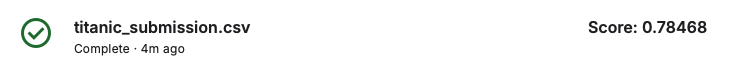

Overall, this project demonstrates the development of a machine learning pipeline for both pre-processing and modelling to make predictions. To further enhance prediction accuracy, potential areas for improvement include:
1.	__Feature Engineering__: Creating new features to better capture underlying patterns in the data.
2.	__Robust Feature Selection__: Utilising methods like Recursive Feature Elimination (RFE) or feature importance from Random Forest Classifiers to refine feature sets.
3.	__Exploring Additional Models__: Experimenting with other models like AdaBoost or stacking different combinations of classifiers which may improve performance.